In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp
import matplotlib.dates as mdates
import json
import re
from datetime import datetime
from matplotlib import cm

In [ ]:
# test colab
raw = pd.read_csv('DataReactionsPresentWriter.csv')
df = pd.read_csv('DataCommentsPresentWriter.csv')
raw['comments_full'] = df['comments_full']

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        200 non-null    int64  
 1   text                           200 non-null    object 
 2   post_text                      200 non-null    object 
 3   shared_text                    14 non-null     object 
 4   original_text                  0 non-null      float64
 5   time                           200 non-null    object 
 6   timestamp                      200 non-null    int64  
 7   image                          0 non-null      float64
 8   image_lowquality               200 non-null    object 
 9   images                         0 non-null      float64
 10  images_description             0 non-null      float64
 11  images_lowquality              200 non-null    object 
 12  images_lowquality_description  200 non-null    obj

## Làm sạch dữ liệu

In [ ]:
# Loại bỏ tất cả các cột không có giá trị khác nào ngoài NaN
raw = raw.dropna(axis=1,how='all')

In [ ]:
# since we only deal with text of posts, image and the relevant column will be deleted
raw.drop(['image_lowquality','images_lowquality','images_lowquality_description','image_id','image_ids'],axis=1,inplace=True)

In [ ]:
# Thay thế các row có reactions nhận giá trị NaN
raw['reactions'] = np.where(raw['reactions'].isnull() == True, "{'like': 0, 'love': 0, 'care': 0,'haha': 0, 'wow': 0, 'sad': 0,'angry': 0}", raw['reactions'])

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          200 non-null    int64  
 1   text             200 non-null    object 
 2   post_text        200 non-null    object 
 3   shared_text      14 non-null     object 
 4   time             200 non-null    object 
 5   timestamp        200 non-null    int64  
 6   video            65 non-null     object 
 7   video_id         65 non-null     float64
 8   video_thumbnail  65 non-null     object 
 9   likes            200 non-null    int64  
 10  comments         200 non-null    int64  
 11  shares           200 non-null    int64  
 12  post_url         200 non-null    object 
 13  link             38 non-null     object 
 14  links            199 non-null    object 
 15  user_id          200 non-null    int64  
 16  username         200 non-null    object 
 17  user_url        

## Phân tích bộ dữ liệu

### Phân tích bài viết mới nhất

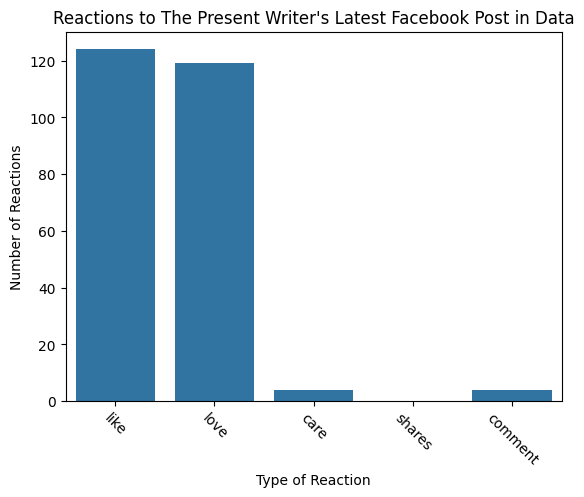

In [ ]:
# Phân tích bài đăng mới nhất
first_row = raw.iloc[0]
# Lượt tương tác
reactions = dict(eval(first_row['reactions']))
# Số lượt chia sẻ
reactions['shares'] = first_row['shares']
# Số lượt comments
reactions['comment'] = first_row['comments']

# plot the reactions
fig, ax = plt.subplots()
ax = sns.barplot(x=list(reactions.keys()), y=list(reactions.values()))
ax.set_title("Reactions to The Present Writer's Latest Facebook Post in Data")
ax.set_ylabel("Number of Reactions")
ax.set_xlabel("Type of Reaction")
plt.xticks(rotation=-45)
plt.show()

###  Đâu là các từ khóa xuất hiện nhiều nhất trong các bài đăng được thu thập?

In [ ]:
# Lấy caption của từng post
df_text = raw[['post_id', 'post_text']]
# Chuyển thành dạng string
text = str(df_text['post_text'])
# Display
df_text

,post_id,post_text
0,919207269569282,20.11 💐
1,918683382955004,‼️ SỔ HIỆU NĂNG THE PRESENT DAY PLANNER ĐÃ CÓ ...
2,918167633006579,🎥 8 Điều Cần Làm Để Viết Tiếng Anh Tốt (cho mọ...
3,917886306368045,Hành động để sống trọn tuổi 20 - 👉Trích từ vid...
4,917723789717630,"""Nếu mình chỉ là một chuyên gia, mình sẽ chỉ l..."
...,...,...
195,705139247642753,/Search like a Scholar: Tìm tài liệu nghiên cứ...
196,700042384819106,🎙 S2E10 Thay đổi hình ảnh trong mắt người khác...
197,700109418145736,/Mình làm gì để kết lại một ngày hiệu quả?/\n\...
198,699405538216124,NOVEMBER DEALS 2 — NHỮNG SẢN PHẨM ĐÁNG ĐẦU TƯ ...


In [ ]:
text

'0                                                20.11 💐\n1      ‼️ SỔ HIỆU NĂNG THE PRESENT DAY PLANNER ĐÃ CÓ ...\n2      🎥 8 Điều Cần Làm Để Viết Tiếng Anh Tốt (cho mọ...\n3      Hành động để sống trọn tuổi 20 - 👉Trích từ vid...\n4      "Nếu mình chỉ là một chuyên gia, mình sẽ chỉ l...\n                             ...                        \n195    /Search like a Scholar: Tìm tài liệu nghiên cứ...\n196    🎙 S2E10 Thay đổi hình ảnh trong mắt người khác...\n197    /Mình làm gì để kết lại một ngày hiệu quả?/\\n\\...\n198    NOVEMBER DEALS 2 — NHỮNG SẢN PHẨM ĐÁNG ĐẦU TƯ ...\n199    ADVANCED ENGLISH w/ CAMBLY\\n\\nCambly đang có đ...\nName: post_text, Length: 200, dtype: object'

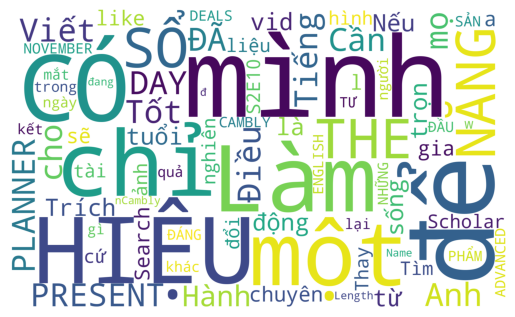

In [ ]:
from wordcloud import WordCloud, STOPWORDS
STOPWORDS = ['dtype','object','post_id','post_text','n']
# Các từ có tần suất xuất hiện cao nhất
wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                       max_words =300,
                       width=2000, height=1200
                        ).generate(text)
# Clear enire figure but let windows open to be reused
plt.clf()
# create an image from 2-dimensional numpy array
plt.imshow(wordcloud)
# hid the axis in the matplot figure
plt.axis('off')
# display
plt.show()

### Đâu là bài viết có lượt tương tác lớn nhất trong bộ dữ liệu?

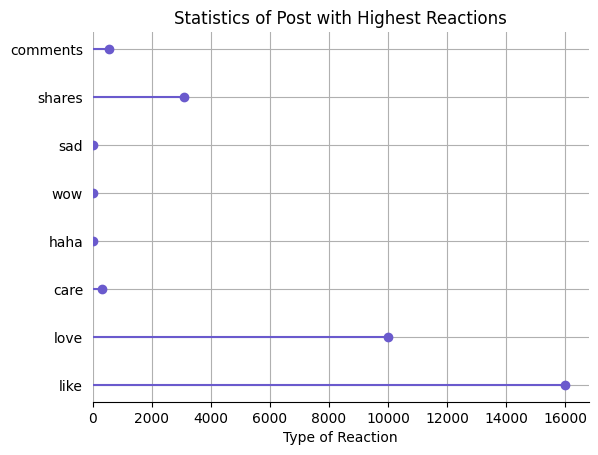

In [ ]:
maxi = raw['reaction_count'].idxmax()
row_max = raw.iloc[maxi]
row_max_reactions = row_max['reactions']
row_max_reactions
max_reactions = dict(eval(row_max_reactions))
max_reactions["shares"] = row_max['shares']
max_reactions["comments"] = row_max['comments']

#plot the reactions
temp = list(max_reactions)
temp = pd.DataFrame(temp)
temp['count'] = list(max_reactions.values())
temp.columns = ['Reactions', 'Count']
temp.set_index('Reactions', inplace=True)

fig, ax = plt.subplots()
plt.hlines(y=temp.index, xmin = 0, xmax = temp, color='slateblue')
plt.plot(temp, temp.index,'o', color='slateblue')
plt.title("Statistics of Post with Highest Reactions")
plt.xlabel("Type of Reaction")
plt.xlim(0, None)
ax.grid(True)
ax.tick_params(bottom=True, left=False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


### Thống kê số lượng bài viết theo tháng

In [ ]:
from datetime import datetime
# Chuyển raw['time'] từ kiểu object sang datetime
raw['time'] = pd.to_datetime(raw['time'])
# Trích xuất tháng và chuyển về kiểu string
raw['month']=raw['time'].apply(lambda x: x.strftime('%B'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   count   12 non-null     int64 
 1   Month   12 non-null     object
dtypes: int64(1), object(1)
memory usage: 320.0+ bytes


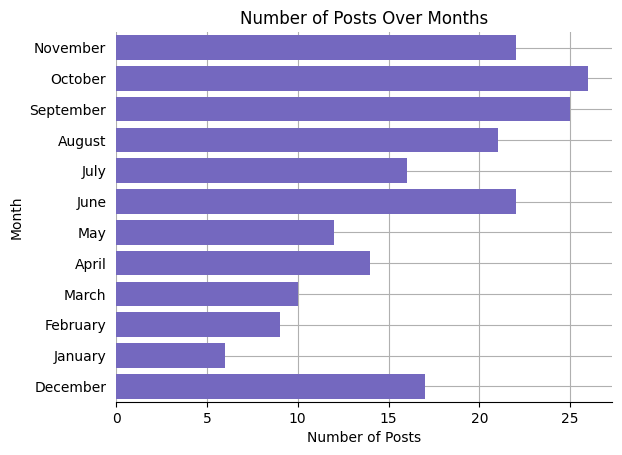

In [ ]:
# Thống kê số lượng bài đăng theo tháng trên tập dữ liệu
plt.clf()
num = raw['month'].value_counts(sort=False)
data = pd.DataFrame(raw['month'].unique(), num)
data.columns = ['Month']

data = data.reset_index()
data.info()
ax1 = sns.barplot(x='count', y='Month',
                     data=data, color='slateblue')
ax1.grid()
ax1.set_axisbelow(True)
plt.title("Number of Posts Over Months")
plt.xlabel('Number of Posts')
sns.despine(left=True)
plt.tick_params(bottom=True, left=False)

### Các mốc thời gian trong ngày mà Fanpage thường xuyên đăng bài viết?

Text(0.5, 1.0, 'Posting Frequency in 24 hours')

<Figure size 640x480 with 0 Axes>

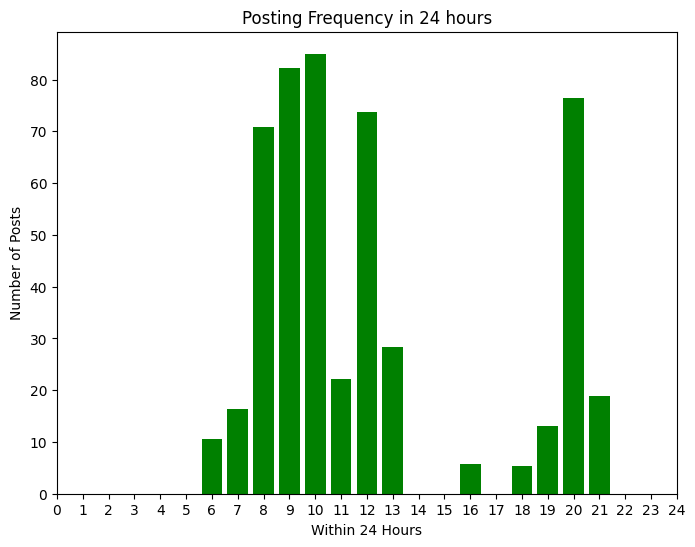

In [ ]:
# Trích giờ từ cột time
plt.clf()
raw['time_no_date'] = raw['time'].dt.hour

fig, ax = plt.subplots(figsize=(8,6))
# Số bài đăng
s = raw['time_no_date'].value_counts()
s_inter = interp.interp1d(np.arange(s.size),s)
s_ = s_inter(np.linspace(0,s.size-1,raw['time_no_date'].size))
ax.bar(raw['time_no_date'],s_,color='green')
ax.set_xticks(ticks=[i for i in range(0,25)])
ax.set_xlabel("Within 24 Hours")
ax.set_ylabel("Number of Posts")
ax.set_title("Posting Frequency in 24 hours")

In [ ]:
raw['time_no_date']

0      10
1       9
2       9
3      20
4      12
       ..
195     8
196     9
197     9
198     9
199    20
Name: time_no_date, Length: 200, dtype: int32

### Số lượt tương tác trong các bài đăng thay đổi như thế nào?

In [ ]:
# Chuyển cột reactions thành list of dictionaries
reacts = raw['reactions'].tolist()
reacts
reaction_list = []
for i in range(len(reacts)):
    reaction_dict = dict(eval(reacts[i]))
    reaction_list.append(reaction_dict)
react = pd.DataFrame(reaction_list)
# Thay các giá trị NaN bằng 0
react.fillna(0,inplace=True)

In [ ]:
# Merge hai dataframe
raw = pd.concat([raw, react],axis=1)
raw.drop(['like'],axis=1,inplace=True)

In [ ]:
# Di chuyển cột likes
raw = raw[[c for c in raw if c not in ['likes','love']] + ['likes','love']]

In [ ]:
# Chuyển kiểu của các cột reactions thành int
raw = raw.astype({'care': int, 'sad': int,'wow': int,'haha': int,'angry': int})
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   post_id          200 non-null    int64         
 1   text             200 non-null    object        
 2   post_text        200 non-null    object        
 3   shared_text      14 non-null     object        
 4   time             200 non-null    datetime64[ns]
 5   timestamp        200 non-null    int64         
 6   video            65 non-null     object        
 7   video_id         65 non-null     float64       
 8   video_thumbnail  65 non-null     object        
 9   comments         200 non-null    int64         
 10  shares           200 non-null    int64         
 11  post_url         200 non-null    object        
 12  link             38 non-null     object        
 13  links            199 non-null    object        
 14  user_id          200 non-null    int64    

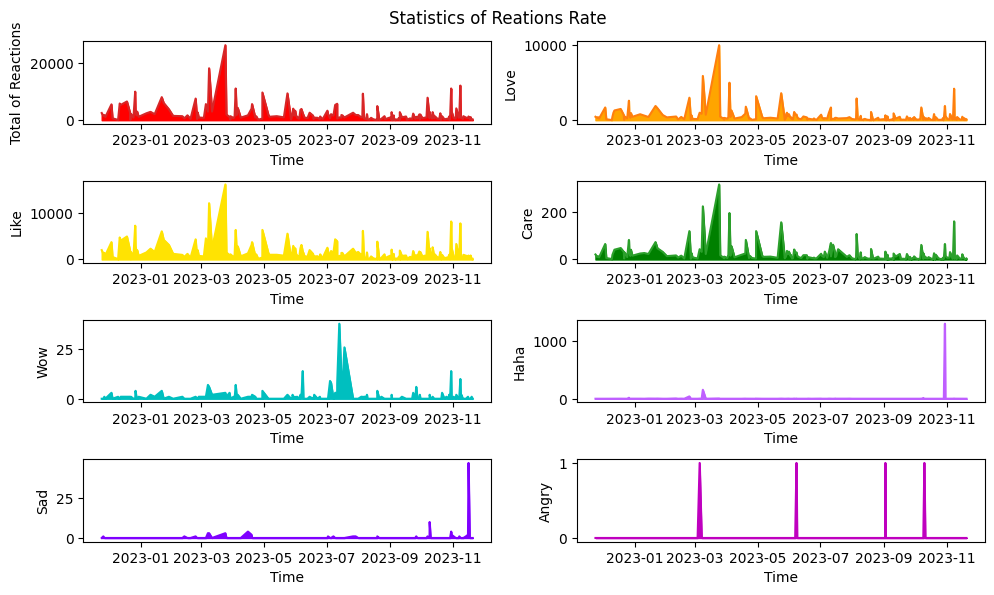

In [ ]:
fig, axs = plt.subplots(4,2,figsize=(10,6))
fig.suptitle('Statistics of Reations Rate')
# total of reactions
axs[0,0].plot(raw['time'],raw['reaction_count'],'tab:red')
axs[0,0].set_xlabel('Time')
axs[0,0].set_ylabel('Total of Reactions')
axs[0,0].fill_between(raw['time'], raw['reaction_count'],color = 'red')
# loves
axs[0,1].plot(raw['time'],raw['love'],'tab:orange')
axs[0,1].set_xlabel('Time')
axs[0,1].set_ylabel('Love')
axs[0,1].fill_between(raw['time'], raw['love'],color = 'orange')
# likes
axs[1,0].plot(raw['time'],raw['likes'],'#FFE302')
axs[1,0].set_xlabel('Time')
axs[1,0].set_ylabel('Like')
axs[1,0].fill_between(raw['time'], raw['likes'],color = '#FFE302')
# care
axs[1,1].plot(raw['time'],raw['care'],'tab:green')
axs[1,1].set_xlabel('Time')
axs[1,1].set_ylabel('Care')
axs[1,1].fill_between(raw['time'], raw['care'],color = 'green')
# wow
axs[2,0].plot(raw['time'],raw['wow'],'c')
axs[2,0].set_xlabel('Time')
axs[2,0].set_ylabel('Wow')
axs[2,0].fill_between(raw['time'], raw['wow'],color = 'c')
# haha
axs[2,1].plot(raw['time'],raw['haha'],'#BF5FFF')
axs[2,1].set_xlabel('Time')
axs[2,1].set_ylabel('Haha')
axs[2,1].fill_between(raw['time'], raw['haha'],color = '#BF5FFF')
# sad
axs[3,0].plot(raw['time'],raw['sad'],'#7f00ff')
axs[3,0].set_xlabel('Time')
axs[3,0].set_ylabel('Sad')
axs[3,0].fill_between(raw['time'], raw['sad'],color = '#7f00ff')
# angry
axs[3,1].plot(raw['time'],raw['angry'],'m')
axs[3,1].set_xlabel('Time')
axs[3,1].set_ylabel('Angry')
axs[3,1].fill_between(raw['time'], raw['angry'],color = 'm')
plt.tight_layout(pad=0.9)

#### Bức tranh tổng quát về số lượng tương tác trên bộ dữ liệu

Text(0.5, 1.0, 'Percentage of Reactions out of Total')

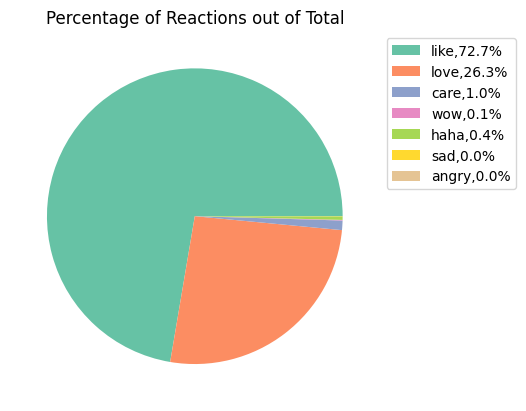

In [ ]:
total = raw['reaction_count'].sum()
total_like = raw['likes'].sum()
total_love = raw['love'].sum()
total_care = raw['care'].sum()
total_wow = raw['wow'].sum()
total_haha = raw['haha'].sum()
total_sad = raw['sad'].sum()
total_angry = raw['angry'].sum()
prop_like = total_like/total * 100
prop_love = total_love/total * 100
prop_care = total_care/total * 100
prop_wow = total_wow/total * 100
prop_haha = total_haha/total * 100
prop_sad = total_sad/total * 100
prop_angry = total_angry/total * 100
plt.pie(x=np.array([total_like,total_love,total_care,total_wow,total_haha,total_sad,total_angry]),
        colors=sns.color_palette('Set2'))
labels = ['like','love','care','wow','haha','sad','angry']
sizes = [prop_like, prop_love, prop_care, prop_wow, prop_haha, prop_sad, prop_angry]
labels = [f'{l},{s:0.1f}%' for l, s in zip(labels, sizes)]
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',labels=labels)
plt.title('Percentage of Reactions out of Total')

In [ ]:
raw

,post_id,text,post_text,shared_text,time,timestamp,video,video_id,video_thumbnail,comments,...,fetched_time,month,time_no_date,care,wow,haha,sad,angry,likes,love
0,919207269569282,20.11 💐\n\nThe Present Writer Shop Vietnam is ...,20.11 💐,The Present Writer Shop Vietnam is feeling gra...,2023-11-20 10:08:47,1700449727,NaN,NaN,NaN,4,...,2023-11-20 22:46:22.612946,November,10,4,0,0,0,0,124,119
1,918683382955004,‼️ SỔ HIỆU NĂNG THE PRESENT DAY PLANNER ĐÃ CÓ ...,‼️ SỔ HIỆU NĂNG THE PRESENT DAY PLANNER ĐÃ CÓ ...,NaN,2023-11-19 09:00:22,1700359222,NaN,NaN,NaN,3,...,2023-11-20 22:46:27.251264,November,9,0,1,0,0,0,95,44
2,918167633006579,🎥 8 Điều Cần Làm Để Viết Tiếng Anh Tốt (cho mọ...,🎥 8 Điều Cần Làm Để Viết Tiếng Anh Tốt (cho mọ...,NaN,2023-11-18 09:11:16,1700273476,NaN,NaN,NaN,15,...,2023-11-20 22:46:29.986807,November,9,5,0,1,0,0,853,270
3,917886306368045,Hành động để sống trọn tuổi 20 - 👉Trích từ vid...,Hành động để sống trọn tuổi 20 - 👉Trích từ vid...,NaN,2023-11-17 20:00:37,1700226037,https://scontent-sin6-4.xx.fbcdn.net/v/t42.179...,6.354972e+14,https://scontent-sin6-4.xx.fbcdn.net/v/t15.525...,2,...,2023-11-20 22:46:55.662295,November,20,6,0,0,0,0,273,41
4,917723789717630,"""Nếu mình chỉ là một chuyên gia, mình sẽ chỉ l...","""Nếu mình chỉ là một chuyên gia, mình sẽ chỉ l...",NaN,2023-11-17 12:17:24,1700198244,NaN,NaN,NaN,3,...,2023-11-20 22:47:00.969371,November,12,8,0,1,0,0,411,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,705139247642753,/Search like a Scholar: Tìm tài liệu nghiên cứ...,/Search like a Scholar: Tìm tài liệu nghiên cứ...,NaN,2022-12-03 08:19:25,1670030365,NaN,NaN,NaN,121,...,2023-11-20 22:53:27.589008,December,8,65,3,0,0,0,3700,1700
196,700042384819106,🎙 S2E10 Thay đổi hình ảnh trong mắt người khác...,🎙 S2E10 Thay đổi hình ảnh trong mắt người khác...,NaN,2022-11-27 09:15:02,1669515302,NaN,NaN,NaN,24,...,2023-11-20 22:53:29.788981,November,9,9,0,1,0,0,896,221
197,700109418145736,/Mình làm gì để kết lại một ngày hiệu quả?/\n\...,/Mình làm gì để kết lại một ngày hiệu quả?/\n\...,NaN,2022-11-26 09:43:02,1669430582,NaN,NaN,NaN,22,...,2023-11-20 22:53:31.454842,November,9,13,1,0,0,0,1400,403
198,699405538216124,NOVEMBER DEALS 2 — NHỮNG SẢN PHẨM ĐÁNG ĐẦU TƯ ...,NOVEMBER DEALS 2 — NHỮNG SẢN PHẨM ĐÁNG ĐẦU TƯ ...,NaN,2022-11-25 09:56:02,1669344962,NaN,NaN,NaN,19,...,2023-11-20 22:53:33.074606,November,9,11,0,0,1,0,1200,320


### Sự tương quan giữa số lượng reactions với các trường khác như số lượng bình luận, độ dài bài viết?

Text(0.5, 1.0, 'Biểu đồ thể hiện sự tương quan giữa các trường dữ liệu')

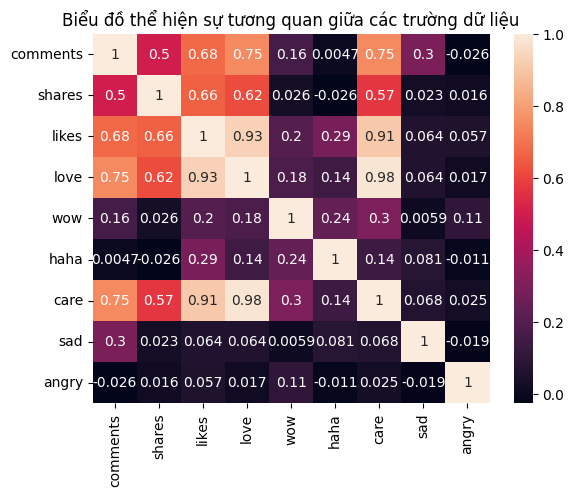

In [ ]:
corr = raw[['comments','shares','likes','love','wow','haha','care','sad','angry']]
# tính hệ số tương quan giữa các trường reactions, comments, shares
corr = corr.corr()
ax = sns.heatmap(corr,annot=True)
ax.set_title('Biểu đồ thể hiện sự tương quan giữa các trường dữ liệu')

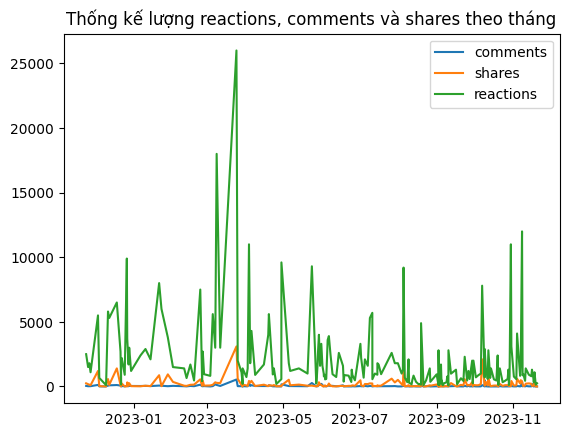

In [ ]:
# line plot
fig, ax = plt.subplots()
ax.plot(raw['time'],raw['comments'],label='comments')
ax.plot(raw['time'],raw['shares'],label='shares')
ax.plot(raw['time'],raw['reaction_count'],label='reactions')
ax.set_title("Thống kế lượng reactions, comments và shares theo tháng")
plt.legend()


In [ ]:
November = raw.loc[raw['month'] == 'November','reaction_count']

### Các keyword xuất hiện nhiều nhất trong comments

In [ ]:
comment_list = raw['comments_full'].tolist()
sum_text = ""
def preprocess_json_string(s):
        s = s.replace("'",'"')
        s = s.replace(': None',': "None"')
        s = s.replace(": ,", ': "None",')
        return s

# print(comment_list[7])

for i in range(len(comment_list)):
    com = comment_list[i]
    # format lại json
    com = preprocess_json_string(com)
    tem_com = re.sub(r'datetime\.datetime\(([^)]*)\)', r'"[\1]"', com)
    # print(tem_com)
    try:
        tem = json.loads(tem_com)
    except (KeyError,ValueError):
        continue
    for j in range(len(tem)):
        # print(i, end=' ')
        # print(j)
        text = tem[j]['comment_text']
        sum_text = sum_text + ' ' + text
sum_text
# tem_com

' Chúc em Chi Nguyễn ngày 20/11 luôn tràn đầy niêm vui và hạnh phúc nhé Em chúc chị ngày 20/11 thật nhiều sức khỏe và hạnh phúc Chúc chị ngày 20/11 đầy niềm vui ạ Chi duyen dang quá ❣️ Link mua các sản phẩm của The Present Writer tại Úc & New Zealand trên Viet Book Alley: https://\nwww.vietbookalle\ny.com.au/\ncollections/\nvendors?q=The+Pr\nesent+Writer\n\n🕊️ Tổng hợp link mua các sản phẩm của The Present Writer tại Việt Nam và nước ngoài: https://\nlinktr.ee/\nthepresentwriter\nshop_vn 👉Xem video đầy đủ: https://\nyoutu.be/\nXjV4KzfyN3U đúng chủ đề em muốn biết luôn, cảm ơn chị 🥰 Cảm ơn chị đã chia sẻ ạ Đúng lúc em đang cần, như tín hiệu cm vũ trụ đó chị ơi 🥰🥰Cảm ơn chị đã chia sẻ Chị Chi ơi, em có xem qua video làm blog và nhận được mail hướng dẫn làm blog, có chút trục trặc vè Bluehost, em không thể nhấp vào xem được mong chị xem qua giúp em nhé ạ. Em cảm ơn chị nhiều! ❤️ Ngan Ngân Anh Vũ Thanh Thanh Hiền Hiếu Ngân xem video mới thoaiii 👉 Xem video đầy đủ tại: https://\nwww.youtube

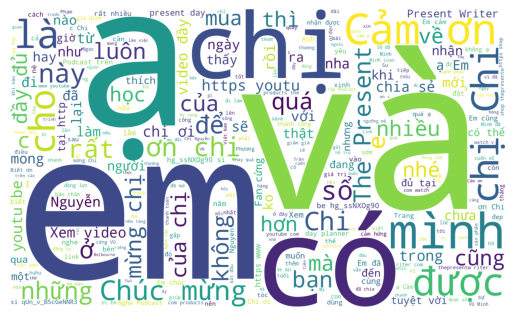

In [ ]:

STOPWORD = ['comment_id','comment_url','object','comments_full','length',"comment_id'",'comment_ur','dtype']
wordcloud = WordCloud(stopwords = STOPWORD,background_color='white',max_words=300,width=2000,height =1200).generate(sum_text)
plt.clf()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Dự đoán số lượt love dựa trên like thông qua linear regression model

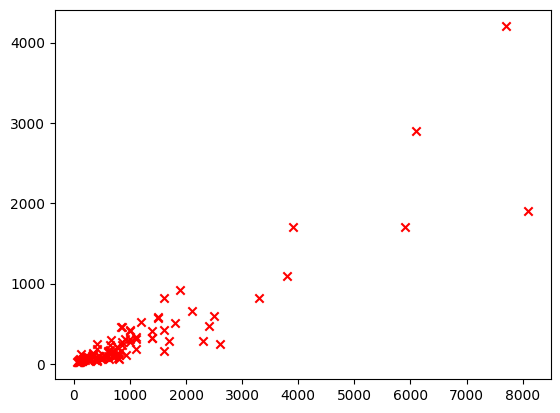

In [ ]:
import copy
import math
x_train = raw['likes'][0:100]
y_train = raw['love'][0:100]
plt.scatter(x_train, y_train, marker='x', c='r')

In [ ]:
def compute_cost(x, y, w, b):
    m = x.shape[0]
    total_cost = 0

    for i in range(m):
        f_wb = w*x[i] + b
        cost = (f_wb - y[i])*(f_wb - y[i])
        total_cost = total_cost + cost
    total_cost = (1/(2*m)) * total_cost

    return total_cost
def compute_gradient(x, y, w, b):
    m = x.shape[0]

    dj_dw = 0
    dj_db = 0

    for i in range(m):
        f_wb = w*x[i] + b
        tmp_djw = (f_wb-y[i])*x[i]
        tmp_djb = f_wb - y[i]
        dj_dw = tmp_djw + dj_dw
        dj_db = tmp_djb + dj_db
    dj_dw = (1/m)*dj_dw
    dj_db = (1/m)*dj_db
    return dj_dw, dj_db
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    m = len(x)

    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(x, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100000:
            cost = cost_function(x, y, w, b)
            J_history.append(cost)

        if i%math.ceil(num_iters/10) == 0:
            w_history.append(w)
    return w, b, J_history, w_history
# test các hàm
initial_w = 2
initial_b = 1

cost = compute_cost(x_train, y_train, initial_w, initial_b)
print(cost)
initial_w = 0
initial_b = 0

tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, initial_w, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw, tmp_dj_db)
test_w = 0.2
test_b = 0.2
tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, test_w, test_b)

print('Gradient at test w, b:', tmp_dj_dw, tmp_dj_db)


4444720.365
Gradient at initial w, b (zeros): -1103463.81 -323.39
Gradient at test w, b: -460281.89800000034 -108.18799999999996


In [ ]:
m = x_train.shape[0]
predicted = np.zeros(m)
init_w = 0.
init_b = 0.

iterations = 1000000
alpha = np.float64(1.0e-10)

w, b,_,_ = gradient_descent(x_train, y_train, init_w, init_b, compute_cost, compute_gradient, alpha, iterations)

for i in range(m):
    predicted[i] = w * x_train[i] + b

plt.plot(x_train, predicted, c='b')
plt.scatter(x_train, y_train, marker='x', c='r')

KeyboardInterrupt: 